<a href="https://colab.research.google.com/github/SoulSync-Tm/D14_MFC4_Soul_Sync_Music_Seperation/blob/main/Music_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!nvidia-smi

Sat Feb  7 13:34:12 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import glob
import json
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

# Settings for the "Original Model"
# These ranges help normalize values between 0 and 1
CONFIG = {
    "MIN_BPM": 60,
    "MAX_BPM": 180,
    "MIN_RMS": 0.001,
    "MAX_RMS": 0.3,
    "SAMPLE_RATE": 22050,
    "DURATION": 30  # Analyze first 30 seconds for speed
}

# Russell's Circumplex Quadrants for labeling
def get_quadrant_label(valence, arousal):
    # 1. Calculate Intensity (Distance from center)
    radius = np.sqrt(valence**2 + arousal**2)

    # 2. Define the "Neutral" Zone (Center of the circle)
    if radius < 0.25:
        return "Neutral / Balanced"

    # 3. Define the Quadrants
    if arousal >= 0:
        if valence >= 0:
            # Top Right: Positive Energy
            return "Euphoric / Energetic" if radius > 0.6 else "Happy / Cheerful"
        else:
            # Top Left: Negative Energy
            return "Aggressive / Angry" if radius > 0.6 else "Anxious / Tense"
    else:
        if valence >= 0:
            # Bottom Right: Positive Calm
            return "Serene / Spiritual" if radius > 0.6 else "Relaxed / Chill"
        else:
            # Bottom Left: Negative Calm
            return "Depressed / Dark" if radius > 0.6 else "Sad / Melancholic"

In [13]:
class RussellEmotionModel:
    def __init__(self, config):
        self.cfg = config

    def _normalize(self, value, min_val, max_val):
        """Scales a value to 0.0 - 1.0 range safely."""
        return np.clip((value - min_val) / (max_val - min_val + 1e-6), 0, 1)

    def calculate_arousal(self, y, sr):
        """
        Derives Arousal (Y-axis) from Energy and Tempo.
        Output: -1.0 (Low Energy) to +1.0 (High Energy)
        """
        # 1. Physical Loudness (RMS Energy)
        rms = np.mean(librosa.feature.rms(y=y))
        norm_rms = self._normalize(rms, self.cfg["MIN_RMS"], self.cfg["MAX_RMS"])

        # 2. Tempo / Pace
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
        norm_tempo = self._normalize(tempo, self.cfg["MIN_BPM"], self.cfg["MAX_BPM"])

        # 3. Beat Intensity (Onset Strength)
        beat_intensity = np.mean(onset_env)
        norm_beat = self._normalize(beat_intensity, 0, 2.0)

        # Weighted Formula for Arousal
        # Loudness and Tempo are the strongest indicators of Arousal
        arousal_score = (0.4 * norm_rms) + (0.4 * norm_tempo) + (0.2 * norm_beat)

        # Map 0-1 to -1 to +1
        return (arousal_score * 2) - 1

    def calculate_valence(self, y, sr):
        """
        Derives Valence (X-axis) from Timbre and Harmony.
        Output: -1.0 (Negative) to +1.0 (Positive)
        """
        # 1. Harmonic vs Percussive Ratio
        # High harmonic energy often feels "smoother" or more positive
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        h_mean = np.mean(librosa.feature.rms(y=y_harmonic))
        p_mean = np.mean(librosa.feature.rms(y=y_percussive))
        ratio = h_mean / (p_mean + 1e-6)
        # Log scale the ratio to handle wide variances
        norm_ratio = self._normalize(np.log1p(ratio), 0, 2.0)

        # 2. Tonal Clarity (Chroma Variance)
        # Clear, distinct notes (High Variance) often sound "brighter" (Major-like)
        # Muddled, noisy notes (Low Variance) often sound "darker"
        chroma = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
        chroma_std = np.mean(np.std(chroma, axis=0))
        norm_clarity = self._normalize(chroma_std, 0.1, 0.3)

        # 3. Spectral Centroid (Brightness)
        # Brighter sounds (High Centroid) can feel more positive
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        norm_brightness = self._normalize(centroid, 500, 3000)

        # Weighted Formula for Valence
        valence_score = (0.4 * norm_ratio) + (0.3 * norm_clarity) + (0.3 * norm_brightness)

        # Map 0-1 to -1 to +1
        return (valence_score * 2) - 1

    def analyze_file(self, file_path):
        try:
            # Load Audio
            y, sr = librosa.load(file_path, sr=self.cfg["SAMPLE_RATE"], duration=self.cfg["DURATION"])

            # Calculate Coordinates
            valence = self.calculate_valence(y, sr)
            arousal = self.calculate_arousal(y, sr)

            # Determine Emotion Label
            label = get_quadrant_label(valence, arousal)

            return {
                "file": os.path.basename(file_path),
                "valence": round(valence, 4),
                "arousal": round(arousal, 4),
                "emotion": label,
                "path": file_path
            }
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None

Found 42 audio files.


Analyzing Emotions:   0%|          | 0/42 [00:00<?, ?it/s]/tmp/ipython-input-3066522385.py:20: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
Analyzing Emotions: 100%|██████████| 42/42 [01:31<00:00,  2.17s/it]



✅ Analysis Complete! Saved to /content/drive/MyDrive/colab_projects/Music/output/russell_features.csv
                                    file  valence  arousal  \
0                         Kannumuzhi.mp3   0.0867   0.2588   
1                          Adi Alaye.mp3   0.1452   0.1874   
2   Eppadi-Vandhaayo-MassTamilan.dev.mp3   0.6321  -0.0914   
3  Dandanakka-Life'u-MassTamilan.dev.mp3   0.3231   0.2285   
4                      Jodi Porutham.mp3   0.2750  -0.1865   

              emotion                                               path  
0    Happy / Cheerful  /content/drive/MyDrive/colab_projects/Music/mu...  
1  Neutral / Balanced  /content/drive/MyDrive/colab_projects/Music/mu...  
2  Serene / Spiritual  /content/drive/MyDrive/colab_projects/Music/mu...  
3    Happy / Cheerful  /content/drive/MyDrive/colab_projects/Music/mu...  
4     Relaxed / Chill  /content/drive/MyDrive/colab_projects/Music/mu...  


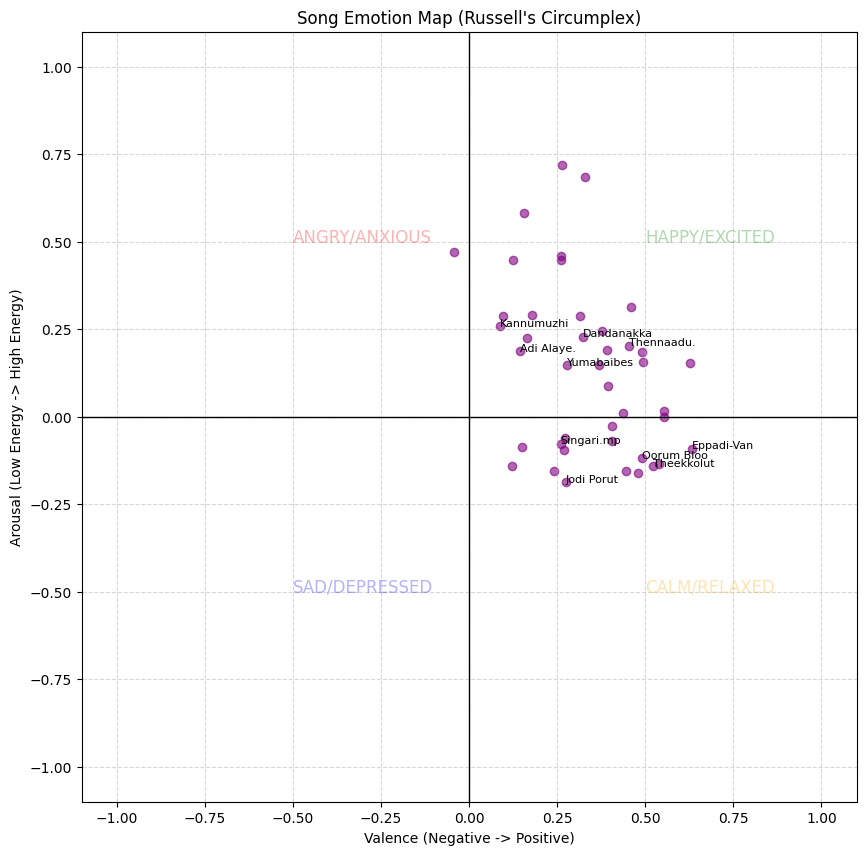

In [14]:
def main():
    # 1. Setup Paths
    # Update this path to where your music folder is in Drive
    music_dir = "/content/drive/MyDrive/colab_projects/Music/music"
    output_csv = "/content/drive/MyDrive/colab_projects/Music/output/russell_features.csv"

    # 2. Initialize Model
    model = RussellEmotionModel(CONFIG)

    # 3. Find Files
    audio_files = []
    for ext in ["*.mp3", "*.wav", "*.flac"]:
        audio_files.extend(glob.glob(os.path.join(music_dir, ext)))
    print(f"Found {len(audio_files)} audio files.")

    # 4. Extract Features
    results = []
    for file_path in tqdm(audio_files, desc="Analyzing Emotions"):
        data = model.analyze_file(file_path)
        if data:
            results.append(data)

    # 5. Save Results
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Analysis Complete! Saved to {output_csv}")
    print(df.head())

    # 6. Visualization (Optional)
    # Plotting the songs on the Circumplex
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 10))
        plt.axhline(0, color='black', linewidth=1) # X-axis
        plt.axvline(0, color='black', linewidth=1) # Y-axis
        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)

        # Quadrant Labels
        plt.text(0.5, 0.5, "HAPPY/EXCITED", fontsize=12, color='green', alpha=0.3)
        plt.text(-0.5, 0.5, "ANGRY/ANXIOUS", fontsize=12, color='red', alpha=0.3)
        plt.text(-0.5, -0.5, "SAD/DEPRESSED", fontsize=12, color='blue', alpha=0.3)
        plt.text(0.5, -0.5, "CALM/RELAXED", fontsize=12, color='orange', alpha=0.3)

        # Plot Songs
        plt.scatter(df['valence'], df['arousal'], c='purple', alpha=0.6)

        # Label a few songs
        for i, txt in enumerate(df['file']):
            if i < 10: # Only label first 10 to avoid clutter
                plt.annotate(txt[:10], (df['valence'][i], df['arousal'][i]), fontsize=8)

        plt.title("Song Emotion Map (Russell's Circumplex)")
        plt.xlabel("Valence (Negative -> Positive)")
        plt.ylabel("Arousal (Low Energy -> High Energy)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
    except ImportError:
        print("Matplotlib not found, skipping plot.")

if __name__ == "__main__":
    main()